### <center> **Deep Learning** </center>
<center> Ron Maor </center>
<hr>

In [ ]:
pip install flax

     |████████████████████████████████| 184kB 4.3MB/s 


In [ ]:
pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=cc0cbd24b844aee705d90e5ee14722354f1a2dfe1133290dc98ea921bf182f14
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
from scipy import linspace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad, value_and_grad, jacfwd
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_multimap
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pandas as pd

from jax.experimental import optimizers
import jax.scipy.stats.norm as norm
from jax.nn import sigmoid, log_sigmoid
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Conv, Dense, Flatten, Relu, Softmax
from jax.experimental import optimizers

import itertools
import numpy.random as npr
from tqdm import trange
from functools import partial
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm


from flax import linen as nn        # The Linen API
from flax import optim              # Optimizers

import tensorflow_datasets as tfds  # TFDS for MNIST

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#from jupyterplot import ProgressPlot

plt.style.use('ggplot')

## Convolutional Neural Nets with MNIST

implementing the following convolutional neural network to perform classification on MNIST data set. 

- Input layer: Accepts 28x28x1 images
- Conv1 layer: 6 filters, filter size 5x5x1, stride 1
- ReLU layer: Accepts and returns a 28x28x6 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Conv2 layer: 12 filters, filter size 5x5x12, stride 1
- ReLU layer: Accepts and returns a 14x14x12 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Conv3 layer: 24 filters, filter size 5x5x24, stride 1
- ReLU layer: Accepts and returns a 7x7x24 tensor
- Fully connected network with 2 hidden layers: Accepts a flattened tensor of dimension 7x7x24 and outputs a 10-dimensional tensor containing the predicted class labels. The hidden layer dimensions should be [256,128,64,10].

##### ***Answer***

In [ ]:
# Creating the required CNN
class CNN(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=6, kernel_size=(5, 5))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=12, kernel_size=(5, 5))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=24, kernel_size=(5, 5))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1)) # Flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)    # There are 10 classes in MNIST
    x = nn.log_softmax(x)
    return x

# Loss and training calculations
def cross_entropy_loss(logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
  return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

def create_optimizer(params, learning_rate, beta):
  optimizer_def = optim.Momentum(learning_rate=learning_rate, beta=beta)
  optimizer = optimizer_def.create(params)
  return optimizer

def get_initial_params(key):
  init_shape = jnp.ones((1, 28, 28, 1), jnp.float32)
  initial_params = CNN().init(key, init_shape)['params']
  return initial_params

def compute_metrics(logits, labels):
  loss = cross_entropy_loss(logits, labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }
  return metrics

@jax.jit
def train_step(optimizer, batch):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grad = grad_fn(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  metrics = compute_metrics(logits, batch['label'])
  return optimizer, metrics



# JIT compile
@jax.jit
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'])
  return compute_metrics(logits, batch['label'])

def train_epoch(optimizer, train_ds, batch_size, epoch, rng):
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  batch_metrics = []

  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    optimizer, metrics = train_step(optimizer, batch)
    batch_metrics.append(metrics)

  training_batch_metrics = jax.device_get(batch_metrics)
  training_epoch_metrics = {
      k: np.mean([metrics[k] for metrics in training_batch_metrics])
      for k in training_batch_metrics[0]}

  print('Training - epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))

  return optimizer, training_epoch_metrics



def eval_model(model, test_ds):
  metrics = eval_step(model, test_ds)    # Evalue the model on the test set
  metrics = jax.device_get(metrics)
  eval_summary = jax.tree_map(lambda x: x.item(), metrics)
  return eval_summary['loss'], eval_summary['accuracy']


In [ ]:
def get_datasets():
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  # Split into training/test sets
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  # Convert to floating-points
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.0
  return train_ds, test_ds

train_ds, test_ds = get_datasets()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Creating the dataset as required

N = 1000 # Number of samples for each digit
t_im = np.zeros((10*N,28,28,1))
t_lbl = np.zeros(10*N)

for k in tqdm((range(10))):
  i = 0
  for j in range(len(train_ds['label'])):
    if train_ds['label'][j] == k:
      t_im[k*N + i,:,:,:] = train_ds['image'][j,:,:,:]
      t_lbl[k*N + i] = train_ds['label'][j]
      i += 1
      if i >= N:
        break

# Permute the data
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

t_im, t_lbl = shuffle(t_im, t_lbl)

# Creating train and test dataset 3/4 & 1/4 from dataset
train_ds2 = {}
train_ds2['image'] = t_im[:7500,:,:,:]
train_ds2['label'] = t_lbl[:7500].astype(int)

test_ds2 = {}
test_ds2['image'] = t_im[7500:,:,:,:]
test_ds2['label'] = t_lbl[7500:].astype(int)

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)


params = get_initial_params(init_rng)


learning_rate = 0.1
beta = 0.9
num_epochs = 10
batch_size = 256

optimizer = create_optimizer(params, learning_rate=learning_rate, beta=beta)

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  optimizer, train_metrics = train_epoch(optimizer, train_ds2, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch
  test_loss, test_accuracy = eval_model(optimizer.target, test_ds2)
  print('Testing - epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

Training - epoch: 1, loss: 1.9010, accuracy: 41.15
Testing - epoch: 1, loss: 0.95, accuracy: 74.60
Training - epoch: 2, loss: 0.3952, accuracy: 88.09
Testing - epoch: 2, loss: 0.21, accuracy: 93.60
Training - epoch: 3, loss: 0.2050, accuracy: 93.37
Testing - epoch: 3, loss: 0.17, accuracy: 95.72
Training - epoch: 4, loss: 0.1217, accuracy: 96.35
Testing - epoch: 4, loss: 0.15, accuracy: 95.68
Training - epoch: 5, loss: 0.0871, accuracy: 97.29
Testing - epoch: 5, loss: 0.12, accuracy: 97.28
Training - epoch: 6, loss: 0.0828, accuracy: 97.33
Testing - epoch: 6, loss: 0.13, accuracy: 96.24
Training - epoch: 7, loss: 0.0598, accuracy: 97.95
Testing - epoch: 7, loss: 0.11, accuracy: 97.32
Training - epoch: 8, loss: 0.0369, accuracy: 98.83
Testing - epoch: 8, loss: 0.12, accuracy: 97.40
Training - epoch: 9, loss: 0.0433, accuracy: 98.46
Testing - epoch: 9, loss: 0.12, accuracy: 97.36
Training - epoch: 10, loss: 0.0395, accuracy: 98.65
Testing - epoch: 10, loss: 0.14, accuracy: 96.64


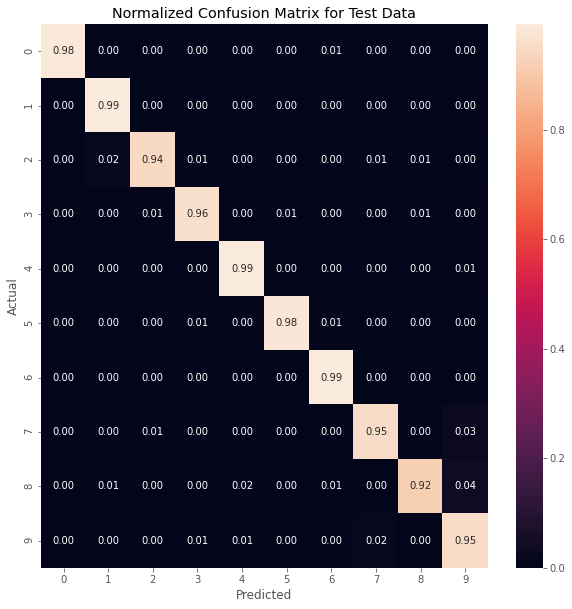

In [ ]:
# Calculating and plotting Confusion Matrix

logits = CNN().apply({'params': optimizer.target}, test_ds2['image'])
pred = np.argmax(logits, axis=-1)

cm = confusion_matrix(test_ds2['label'], pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix for Test Data')
plt.show(block=False)

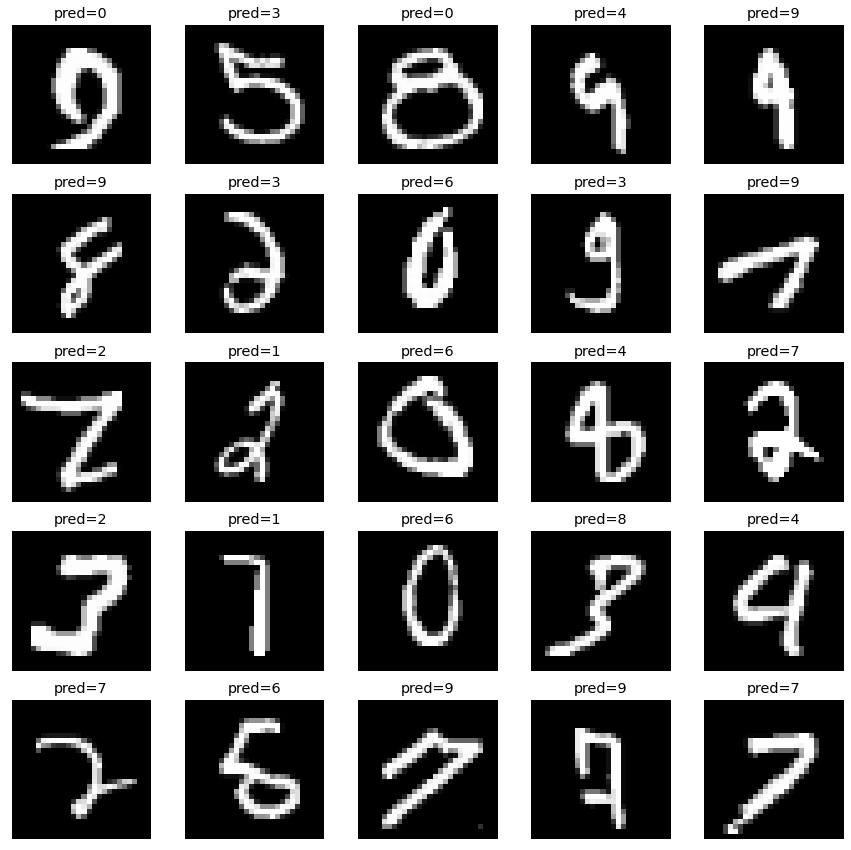

In [ ]:
# Plotting some of the error predictions

error_idxs, = jnp.where(test_ds2['label'] != logits.argmax(axis=1))

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)


# Show some of them.
show_img_grid(
    [test_ds2['image'][idx] for idx in error_idxs[:25]],
    [f'pred={logits[idx].argmax()}' for idx in error_idxs[:25]],
)

## Van de Pol Oscillator & LSTM

The Van der Pol oscillator is composed of two coupled first-order differential equations that are used to characterize many models in biological and physical sciences (e.g. as a model for action potential of neurons). The system of ODEs is given by:

$$ \dot{x} = \mu (x - \frac{1}{3} x^3 - y) $$

$$ \dot{y} = \frac{1}{\mu} x $$ <br>

where $x$ is a state of the system, $y$ another state of the system, and $\dot{x}$ and $\dot{y}$ represent the evolution of the states with respect to time. The value $μ$ is a parameter (constant) is a positive constant. <br><br>

1. Create a time-series data-set by using SciPy to integrate this system in the interval $t ∈ [ 0 , 50 ]$ using $2 , 000$ time-steps for $μ = 5$ using an initial condition of $x ( t = 0 ) = 0.1$ , $y ( t = 0 ) = 0.5$. Create two plots: one for the state trajectories (the $x$ -axis will represent time $t$ and the $y$ -axis the system states $( x , y )$ ) and one for the system trajectories, so the $x$ -axis will correspond to state x and the $y$ -axis to state $y$.

#### ***Answer (1)***

Text(0.5, 1.0, 'System Trajectories')

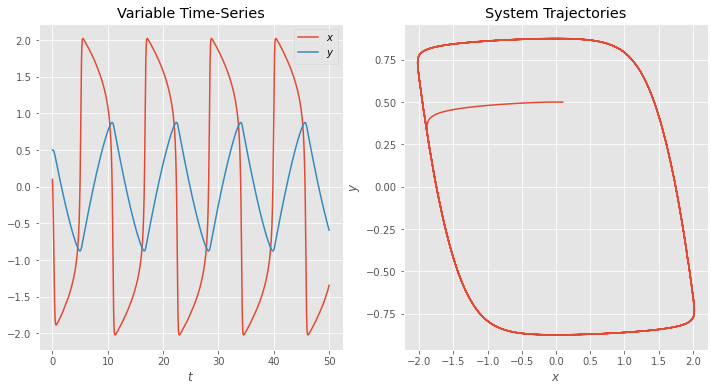

In [ ]:
def vdp(t, z):
    x, y = z
    return [mu*(x - (1/3)*x**3 - y), (1/mu)*x]

t_0, t_f = 0, 50
x0 = 0.1
y0 = 0.5

t = np.linspace(t_0, t_f, 2000)

mu = 5
sol = solve_ivp(vdp, [t_0, t_f], [x0, y0], t_eval=t)

#Plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.set_title('Variable Time-Series')
ax1.plot(sol.t, sol.y[0], label=r'$x$')
ax1.plot(sol.t, sol.y[1], label=r'$y$')
ax1.set_xlabel(r'$t$')
ax1.legend()

ax2.plot(sol.y[0], sol.y[1])
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
ax2.set_title('System Trajectories')

2. Implement a Long Short-Term Memory (LSTM) recurrent neural network with 8 lags, one hidden layer with 20 neurons, and a hyperbolic tangent activation function. Train the network using the first $2/3$ of your data-set for $20 , 000$ stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. Use the trained model to perform one-step-ahead predictions until the final time $T = 60$ , and compare them against the true data. Plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_{2}$ norm.

#### ***Answer (2)***

In [ ]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.experimental import optimizers
from jax.ops import index_update, index

import itertools
from functools import partial
from tqdm.notebook import trange, tqdm
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from jax.nn import sigmoid

In [ ]:
def RNN(in_dim, out_dim, hidden_dim, num_lags):
    # Define init function
    def init(rng_key):
        # Define methods for initializing the weights
        def glorot_normal(rng_key, size):
          in_dim = size[0]
          out_dim = size[1]
          glorot_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
          return glorot_stddev*random.normal(rng_key, (in_dim, out_dim))
        # Inputs
        Ui = glorot_normal(rng_key, (in_dim, hidden_dim))
        bi = np.zeros(hidden_dim)
        Uf = glorot_normal(rng_key, (in_dim, hidden_dim))
        bf = np.zeros(hidden_dim)
        Uo = glorot_normal(rng_key, (in_dim, hidden_dim))
        bo = np.zeros(hidden_dim)
        Us = glorot_normal(rng_key, (in_dim, hidden_dim))
        bs = np.zeros(hidden_dim)
        # Transition dynamics
        Wi = np.eye(hidden_dim)
        Wf = np.eye(hidden_dim)
        Wo = np.eye(hidden_dim)
        Ws = np.eye(hidden_dim)
        # Outputs
        V = glorot_normal(rng_key, (hidden_dim, out_dim))
        c = np.zeros(out_dim)
        return (Ui, bi, Wi,
                Uf, bf, Wf,
                Uo, bo, Wo,
                Us, bs, Ws,
                V, c)
    # Define apply function
    def apply(params, input):
        Ui,bi,Wi,Uf,bf,Wf,Uo,bo,Wo,Us,bs,Ws, V, c = params
        H = np.zeros((input.shape[1], hidden_dim))
        st = np.zeros((input.shape[1], hidden_dim))
        for i in range(num_lags):
            it = sigmoid(np.matmul(H, Wi) + np.matmul(input[i,:,:], Ui) + bi)
            ft = sigmoid(np.matmul(H, Wf) + np.matmul(input[i,:,:], Uf) + bf)
            st_t = np.tanh(np.matmul(H, Ws) + np.matmul(input[i,:,:], Us) + bs)
            st = np.multiply(ft,st) + np.multiply(it, st_t)
            ot = sigmoid(np.matmul(H, Wo) + np.matmul(input[i,:,:], Uo) + bo)
            H = np.multiply( ot, np.tanh(st) )
        H = np.matmul(H, V) + c
        return H
    return init, apply

In [ ]:
def create_lags(data, L):
    N = data.shape[0] - L
    D = data.shape[1]
    X = np.zeros((L, N, D))
    Y = np.zeros((N, D))
    for i in range(0,N):
        X = index_update(X, index[:,i,:], data[i:(i+L), :])
        Y = index_update(Y, index[i,:], data[i+L, :])
    return X, Y

In [ ]:
class Seq2seq():
  def __init__(self, dataset, num_lags, hidden_dim, rng_key = random.PRNGKey(0)):
    # Normalize across data-points dimension
    self.mean, self.std = dataset.mean(0), dataset.std(0)
    dataset = (dataset - self.mean)/self.std

    # Create the lagged normalized trainind data
    # X: L x N x D
    # Y: N x D
    self.X, self.Y = create_lags(dataset, num_lags)
    in_dim = self.X.shape[-1]
    out_dim = self.Y.shape[-1]

    # Initialization and evaluation functions
    self.net_init, self.net_apply = RNN(in_dim, out_dim, hidden_dim, num_lags)

    # Initialize parameters, not committing to a batch shape
    self.net_params = self.net_init(rng_key)

    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(1e-3)
    self.opt_state = self.opt_init(self.net_params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

  def loss(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss = np.mean((y - y_pred)**2)
    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[:, batch_idx, :], self.Y[batch_idx, :]

  def train(self, num_epochs = 100, batch_size = 64):
    n = self.X.shape[1]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover)
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      self.net_params = self.get_params(self.opt_state)
      loss_value = self.loss(self.net_params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  @partial(jit, static_argnums=(0,))
  def predict(self, params, inputs):
    Y_pred = self.net_apply(params, inputs)
    return Y_pred

In [ ]:
rng_key = random.PRNGKey(0)

dataset = np.stack( (sol.y[0], sol.y[1]) , axis=1)

# Use 2/3 of all data as training Data
train_size = int(len(dataset) * (2.0/3.0))
train_data = dataset[0:train_size,:]

# Model creation
num_lags = 8
hidden_dim = 20
model = Seq2seq(train_data, num_lags, hidden_dim, rng_key)

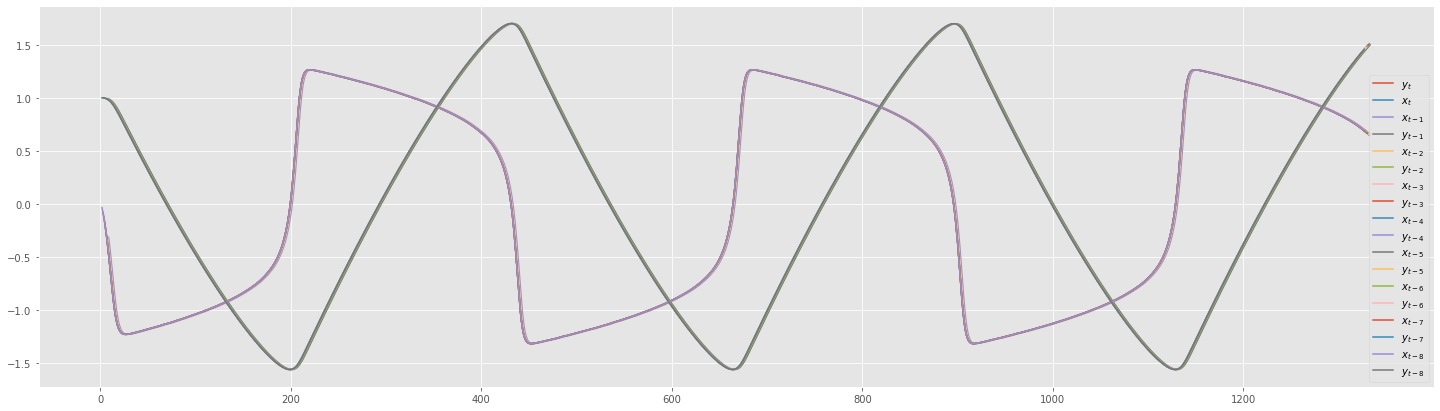

In [ ]:
N = model.Y.shape[0]
t1 = np.linspace(0, 50, len(dataset[num_lags:,0]))
t2 = np.linspace(0, 50, len(pred))

plt.figure(figsize=(25,7))
plt.plot(np.arange(num_lags, N+num_lags), model.Y[:,0], label = '$y_t$')
plt.plot(np.arange(num_lags, N+num_lags), model.Y[:,1], label = '$x_t$')
for i in range(num_lags):
  plt.plot(np.arange(num_lags-i+1, N+num_lags-i+1), model.X[num_lags-i+1,:,0], label = '$x_{t-%d}$' % (i+1))
  plt.plot(np.arange(num_lags-i+1, N+num_lags-i+1), model.X[num_lags-i+1,:,1], label = '$y_{t-%d}$' % (i+1))
plt.legend()

In [ ]:
model.train(num_epochs = 500, batch_size = 128)

In [ ]:
opt_params = model.net_params
# One-step ahead prediction (normalized)
N, D = dataset.shape
pred = np.zeros((N-num_lags, D))
X_tmp =  model.X[:,0:1,:]
for i in trange(N-num_lags):
    pred = index_update(pred, index[i:i+1], model.net_apply(opt_params, X_tmp))
    X_tmp = index_update(X_tmp, index[:-1,:,:], X_tmp[1:,:,:])
    X_tmp = index_update(X_tmp, index[-1,:,:], pred[i])
# De-normalize predictions
pred = pred*model.std + model.mean
error = np.linalg.norm(dataset[num_lags:] - pred, 2)/np.linalg.norm(dataset[num_lags:], 2)
print('Relative L2 prediction error: %e' % (error))


Relative L2 prediction error: 1.326407e-01


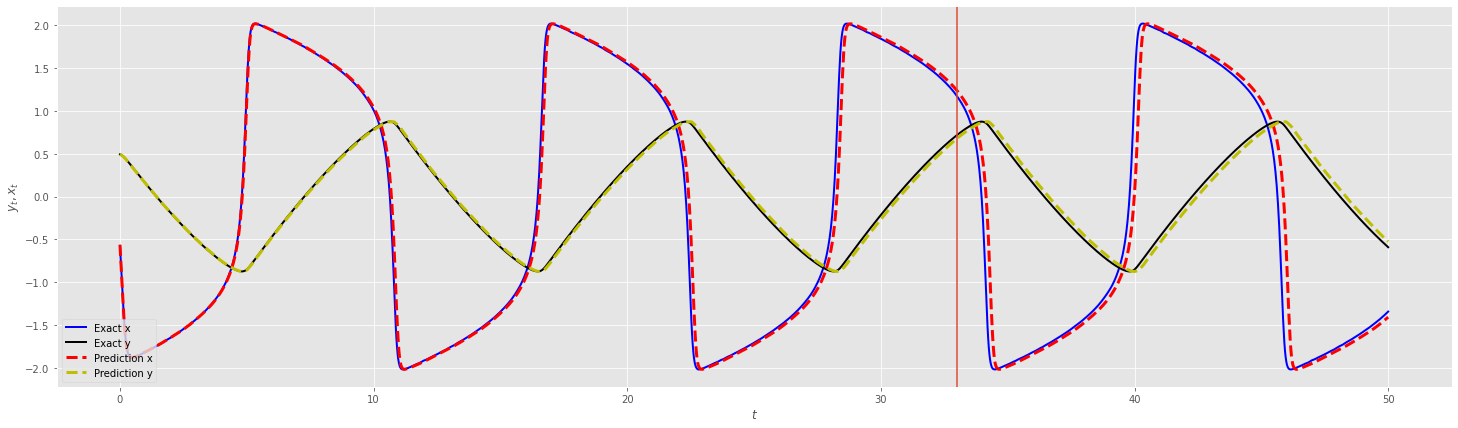

In [ ]:
plt.figure(figsize=(25,7))
t1 = np.linspace(0, 50, len(dataset[num_lags:,0]))
t2 = np.linspace(0, 50, len(pred[:,0]))
plt.plot(t1, dataset[num_lags:,0], 'b-', linewidth = 2, label = "Exact x")
plt.plot(t1, dataset[num_lags:,1], 'k-', linewidth = 2, label = "Exact y")
plt.plot(t2, pred[:,0], 'r--', linewidth = 3, label = "Prediction x")
plt.plot(t2, pred[:,1], 'y--', linewidth = 3, label = "Prediction y")
# plt.plot(X.shape[1]*np.ones((2,1)), np.linspace(-1.75,1.75,2), 'k--', linewidth=2)
plt.axvline(int(50 * (2.0/3.0)))
plt.axis('tight')
plt.xlabel('$t$')
plt.ylabel('$y_t , x_t$')
plt.legend(loc='lower left')

## Physics-Informed Neural Networks (PINNs)

Implement a physics-informed neural network (Raissi, Perdikaris, & Karniadakis, 2017) to solve the Burgers’ equation:

$$ u_t + u u_x - \nu u_{xx} = 0, \quad \nu=0.01/\pi, \quad x\in[-1, 1], t\in[0,1] $$ <br>

$$ u(0,x) = -\sin(\pi x), \quad u(t,-1) = u(t,1) = 0 $$

Plot your solution and report the relative $\mathbb{L}_{2}$ prediction error against the reference solution provided

#### ***Answer***

In [ ]:
#Upload burgers_shock.mat file
from google.colab import files
uploaded = files.upload()

Saving burgers_shock.mat to burgers_shock.mat


In [ ]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.experimental import optimizers

import itertools
from functools import partial
from tqdm.notebook import trange, tqdm
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [ ]:
#Building the MLP

def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [ ]:
class NeuralNetRegression():
  def __init__(self, X, y, X_f, layers, rng_key = random.PRNGKey(0)):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    #X = (X - self.Xmean)/self.Xstd
    #y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.layers = layers
    self.X_f = X_f

    # Use stax to set up network initialization and evaluation functions
    self.net_init, self.net_apply = MLP(layers)

    # Initialize parameters, not committing to a batch shape
    params = self.net_init(rng_key)

    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(1e-4)
    self.opt_state = self.opt_init(params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

  def u_loss1(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss_u = (y - y_pred)**2
    return loss_u

  def net_u(self, params, x, t):
    inputs = np.stack([x, t])
    u = self.net_apply(params, inputs)
    return u[0]

  def net_f1(self, params, X_f):
    x, t = X_f
    #Derivatives
    u = self.net_u(params, x, t)
    u_t = grad(self.net_u, 2)(params, x, t)
    u_x = grad(self.net_u, 1)(params, x, t)
    u_xx = grad(grad(self.net_u, 1), 1)(params, x, t)
    #Residual
    res = (u_t + u*u_x - (0.01/np.pi)*u_xx)**2
    return res

  def loss(self, params, batch):
    u_loss = lambda x: self.u_loss1(params, x)
    f_loss = lambda x: self.net_f1(params, x)
    loss_u = (1/300)*np.sum(vmap(u_loss)(batch))
    loss_res = (1/10000)*np.sum(vmap(f_loss)(self.X_f))
    loss = loss_u
    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover)
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      params = self.get_params(self.opt_state)
      loss_value = self.loss(params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    #X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.net_apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    #y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

  def compute_activations(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    def MLP_pass(params, inputs):
        H = []
        for W, b in params[:-1]:
              outputs = np.dot(inputs, W) + b
              inputs = np.tanh(outputs)
              H.append(inputs)
        return H
    # Get predictions
    pred_fn = lambda x: MLP_pass(params, x)
    activations = vmap(pred_fn)(X_star)
    return activations

In [ ]:
import scipy.io
import numpy as np
from pyDOE import lhs


np.random.seed(1234)

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

# Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
Exact_u = np.real(data['usol']).T # T x N

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]

N_u = 300 #Boundary data
N_f = 1000 #Collocation points

# Domain bounds (lowerbounds upperbounds) [x, t]
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)
# Getting the initial conditions (t=0)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact_u[0:1,:].T
# Getting the lowest boundary conditions (x=-1)
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact_u[:,0:1]
# Getting the highest boundary conditions (x=1)
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact_u[:,-1:]
# Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])


# Generating the x and t collocation points for f, with each having a N_f size
# We pointwise add and multiply to spread the LHS over the 2D domain
X_f_train = lb + (ub-lb)*lhs(2, N_f)

# Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
X_u_train = X_u_train[idx,:]
# Getting the corresponding u_train
u_train = u_train [idx,:]

idx = np.random.choice(X_star.shape[0], 3000, replace=False)
Xff_train = X_star[idx,:]
Xff_u_train = u_star[idx,:]

In [ ]:
import jax.numpy as np

#8 hidden layers with tanh activation
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
model = NeuralNetRegression(Xff_train, Xff_u_train, X_f_train, layers)

In [ ]:
model.train(num_epochs = 300, batch_size = 64)

In [ ]:
#Calculating predictions and L2 error

opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, X_star)

l2_err = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('The L2 error is: {:0.5f}'.format(l2_err))

The L2 error is: 0.08621


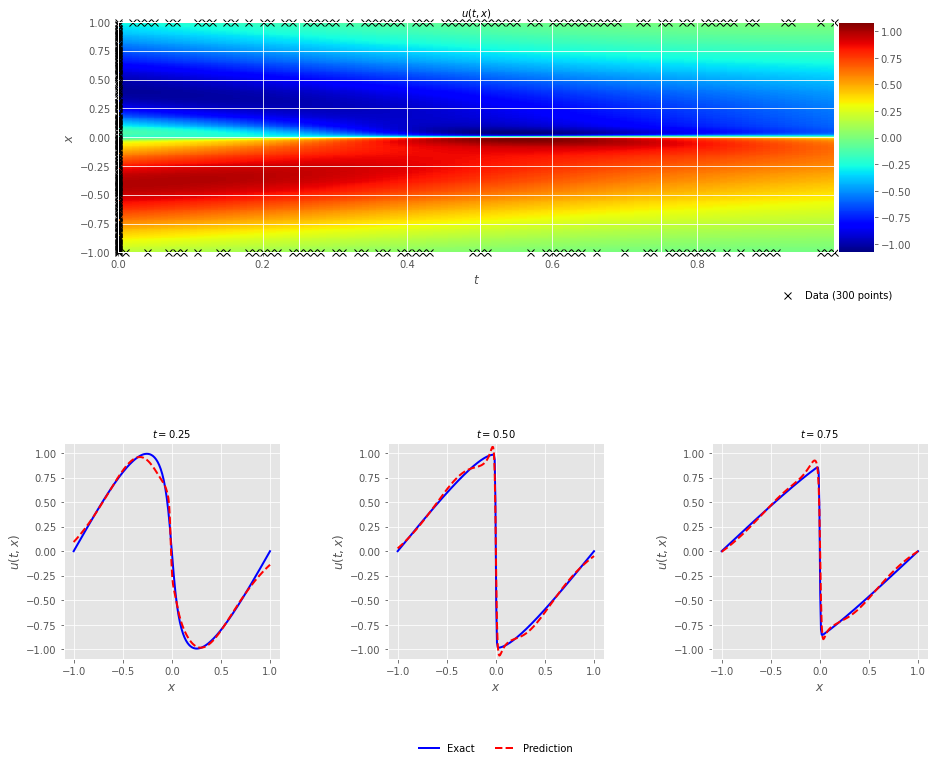

In [ ]:
#Plotting

from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t,):
    fig, ax = plt.subplots(figsize=(15,15))
    #ax.axis('off')

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

    ####### Row 0: u(t,x) ##################
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='jet',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 7, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
    ax.set_title('$u(t,x)$', fontsize = 10)

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_u[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_u[50,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_u[75,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.75$', fontsize = 10)

    plt.show()

plot_results(X_star, u_pred.flatten(), X_u_train, u_train,
  Exact_u, X, T, x, t)